# Transfer Learning 

## CIFAR

**The typical transfer-learning workflow**

https://keras.io/guides/transfer_learning/

This leads us to how a typical transfer learning workflow can be implemented in Keras:

    1. Instantiate a base model and load pre-trained weights into it.
    2. Freeze all layers in the base model by setting trainable = False.
    3. Create a new model on top of the output of one (or several) layers from the base model.
    4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

    1. Instantiate a base model and load pre-trained weights into it.
    2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
    3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once on your data, rather than once per epoch of training. So it's a lot faster & cheaper.

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from keras.datasets import cifar10

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print (x_train.shape, y_train.shape)

x_train  /= 255
x_test /= 255

(50000, 32, 32, 3) (50000, 10)


In [3]:
img_width, img_height = 32, 32
epochs = 50

In [4]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [5]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [6]:
# Freeze the layers which you don't want to train. 
for layer in model.layers[:20]:
    layer.trainable = False

In [7]:
#notice the new number of trainable parameters
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [8]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(model.input, predictions)

In [9]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [10]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])


In [11]:
# Fit model
epochs = 5 #0
batch_size=32
history = model_final.fit(x_train, y_train, 
                    batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(x_test,y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 16s 8ms/step - loss: 1.9595 - accuracy: 0.2961 - val_loss: 1.6122 - val_accuracy: 0.4423
Epoch 2/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5843 - accuracy: 0.4399 - val_loss: 1.4205 - val_accuracy: 0.5042
Epoch 3/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.4435 - accuracy: 0.4894 - val_loss: 1.3345 - val_accuracy: 0.5283
Epoch 4/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3650 - accuracy: 0.5189 - val_loss: 1.2804 - val_accuracy: 0.5506
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3139 - accuracy: 0.5382 - val_loss: 1.2416 - val_accuracy: 0.5618


In [12]:
score = model_final.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [1.241562008857727, 0.5618000030517578]


Text(0.5, 1.0, 'Loss Curves')

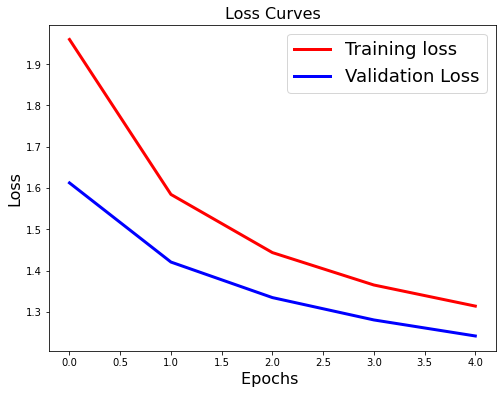

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)